In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

from MINOV.novelty import compute_MI_novelty
from utils import *

from pymatgen.core import Structure

import textalloc as ta
import matplotlib.pyplot as plt
import matplotlib as mpl
from style import mpl_style

import warnings
warnings.filterwarnings("ignore")

Custom matplotlib styles have been applied.


/Users/andrewf/miniconda3/envs/MINOV/lib/python3.10/site-packages/ElMD/ElMD.py:32: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
MAT_DS = "perovskite_dataset"
DS_PATH = os.path.join("data", MAT_DS)
# get all cif files in folder
files = [file for file in os.listdir(DS_PATH) if ".cif" in file]

structures = []
formulas = []
space_group_numbers = []
unit_cell_vols = []
for filename in files:
    structure = Structure.from_file(os.path.join(DS_PATH, filename))
    structures.append(structure)
    formulas.append(str(structure.formula))
    space_group_numbers.append(structure.get_space_group_info()[1]) 
    unit_cell_vols.append(structure.volume)


data = pd.DataFrame({"formula": formulas, "structure": structures, "spacegroup": space_group_numbers, "volume": unit_cell_vols, "filename": files})
data['anion_class'] = data['formula'].apply(lambda x: re.sub(r'[0-9]', '', x.split(" ")[-1]))

In [3]:
data, mi_data = compute_MI_novelty(
    data = data,
    compute_metrics = None,
    precomputed_metrics={
        "lostop": "perovskite_dataset_lostop_dm.npy",
        "elmd": "perovskite_dataset_elmd_dm.npy",
        },
    data_dir="precomputed",
    data_prefix=MAT_DS,
)

MI cutoff for lostop: 0.7419771039783852
MI cutoff for elmd: 6.898492462311557


### Plot MI Profiles for LoStOP and ElMD

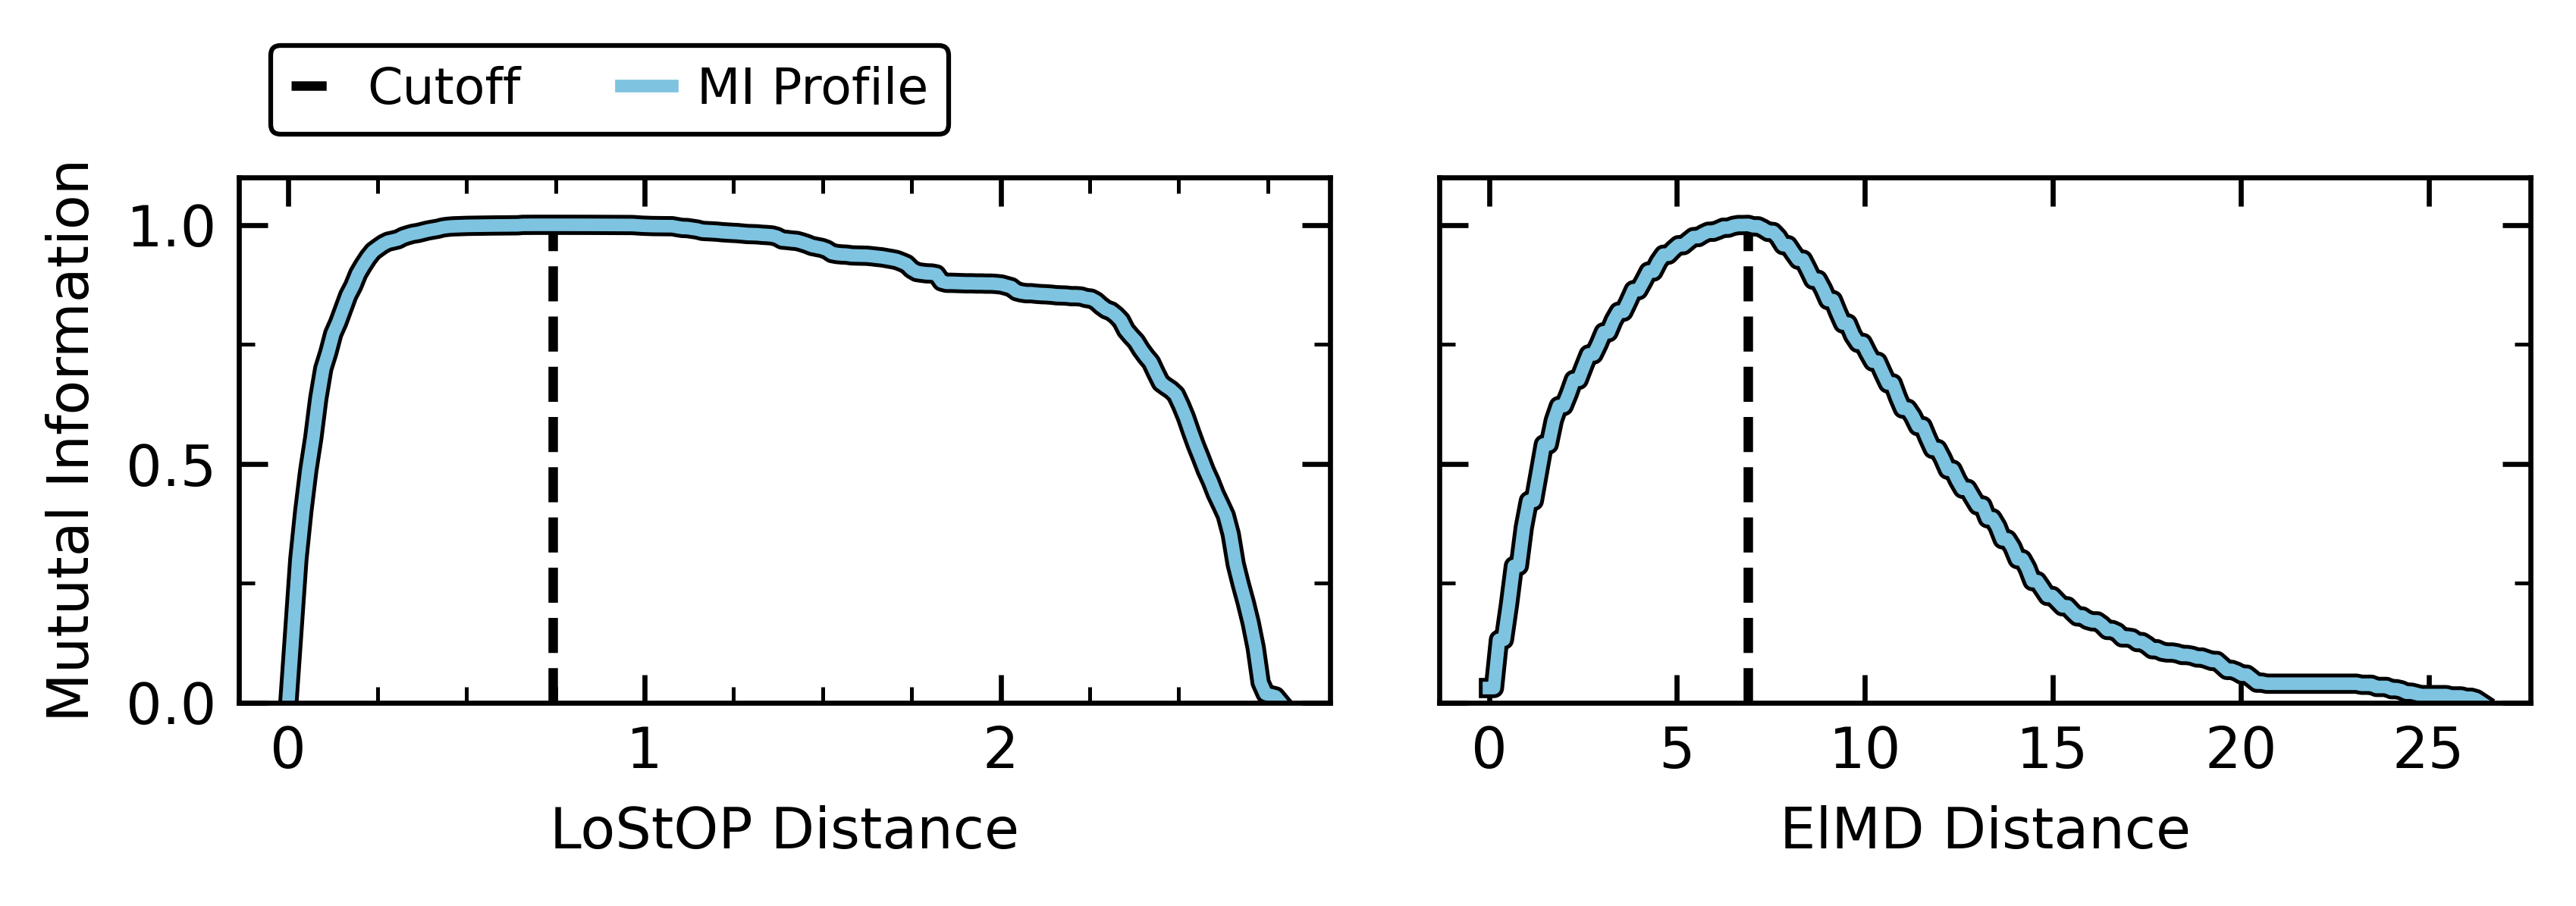

In [4]:
fig, ax = plt.subplots(ncols=2, figsize=(6.5, 1.5), sharey=True, dpi=600)
plt.subplots_adjust(wspace=0.1)

ax[0].vlines(x=mi_data['lostop']['cutoff'], ymin=0, ymax=1.0, color='black', lw=1.5, ls='--', label='Cutoff')
ax[0].plot(mi_data['lostop']['tau'], mi_data['lostop']['mi_profile'], color='black', lw=3.2,)
ax[0].plot(mi_data['lostop']['tau'], mi_data['lostop']['mi_profile'], color='#7EC3E0', lw=2, label='MI Profile')
ax[0].set_yticks([0, 0.5, 1.0])
ax[0].set_ylim(0, 1.1)
ax[0].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
ax[0].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
ax[0].set_ylabel("Mututal Information")
ax[0].set_xlabel("LoStOP Distance")

ax[1].vlines(x=mi_data['elmd']['cutoff'], ymin=0, ymax=1, color='black', lw=1.5, ls='--', label='Cutoff')
ax[1].plot(mi_data['elmd']['tau'], mi_data['elmd']['mi_profile'], color='black', lw=3.2,)
ax[1].plot(mi_data['elmd']['tau'], mi_data['elmd']['mi_profile'], color='#7EC3E0', lw=2, label='MI Profile')
ax[1].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax[1].set_xlabel("ElMD Distance")

legend = ax[0].legend(loc='lower center', fontsize=8, frameon=True, framealpha=1.0, labelspacing=0.25, bbox_to_anchor=(0.34, 1.0), ncol=2)
legend.get_frame().set_linewidth(0.75)

plt.show()

### Plot material densities along ElMD and LoStOP axes

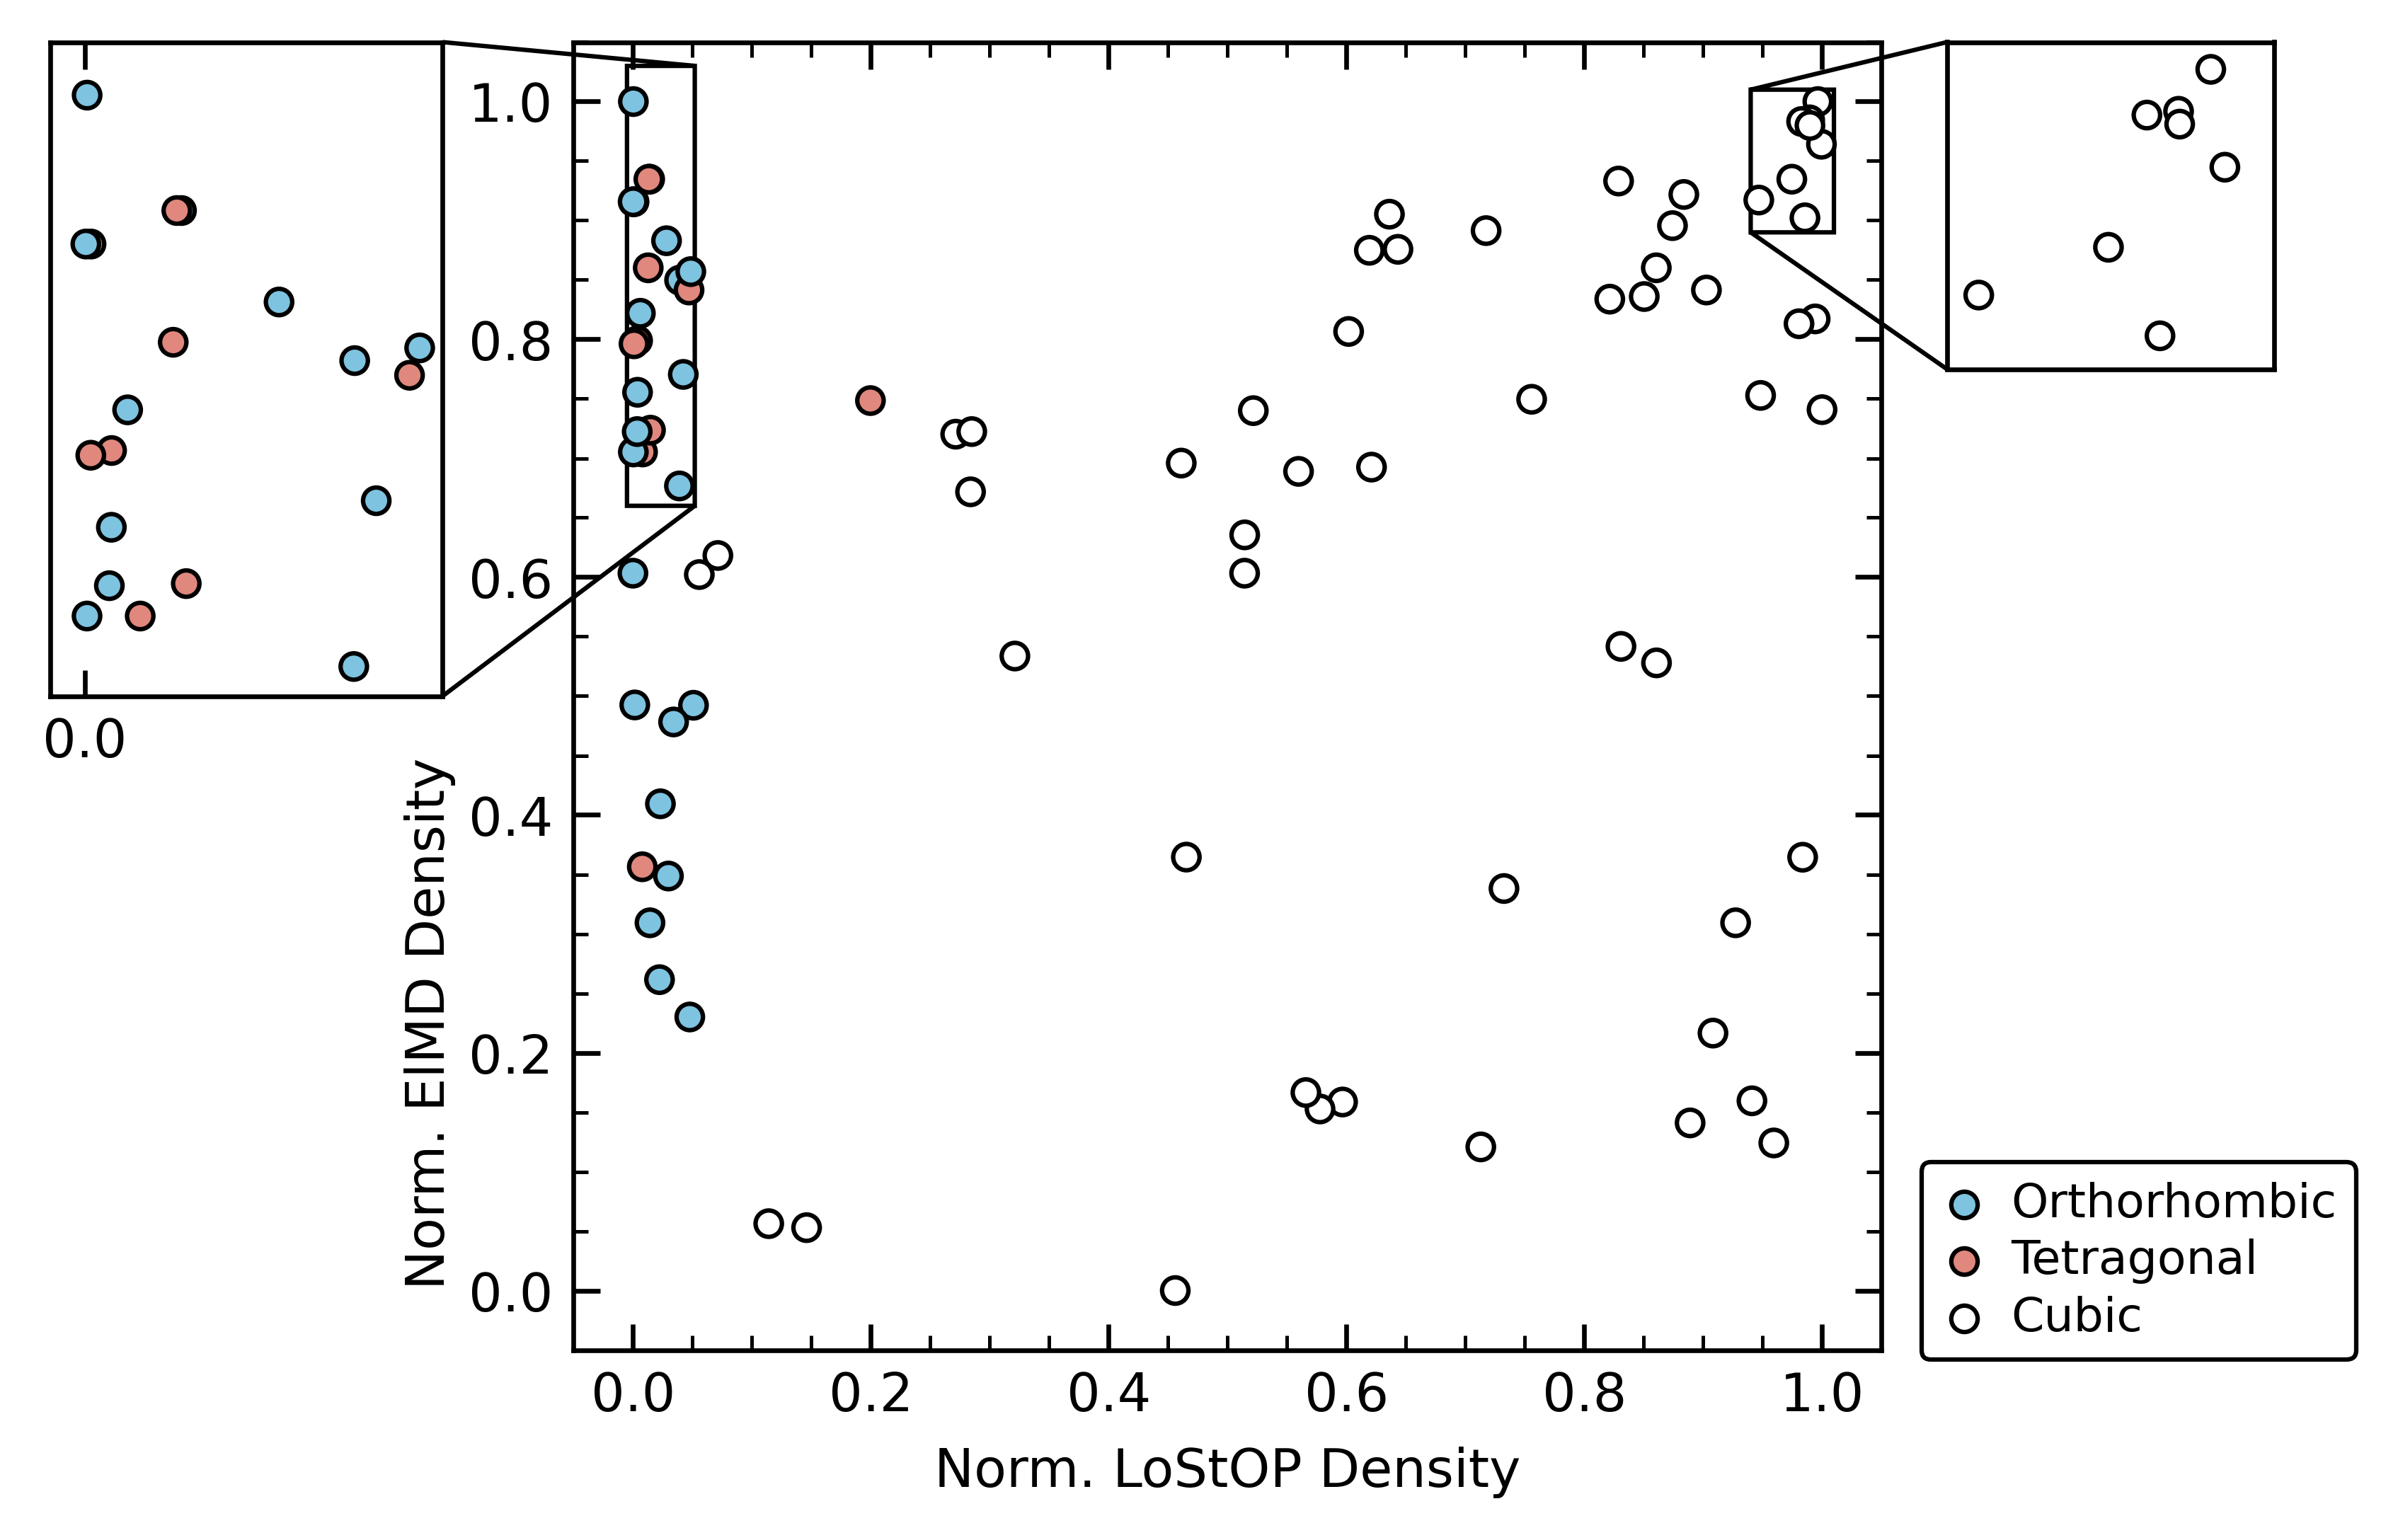

In [5]:
scaled_df = data.copy()
scaled_df[['lostop_density', 'elmd_density']] = MinMaxScaler().fit_transform(scaled_df[['lostop_density', 'elmd_density']])

fig, ax = plt.subplots(figsize=(6.5, 4), dpi=600)
ax.set_aspect('equal')

cmap = mpl.colors.ListedColormap(["#7EC3E0", "#E0877E", "#FFF"]) # blue, red, white

ax.scatter(scaled_df['lostop_density'], scaled_df['elmd_density'], c=scaled_df['spacegroup'], cmap=cmap, s=20, zorder=9, lw=0.75, ec='k')

ax.scatter([],[], c='#7EC3E0', label='Orthorhombic', s=20, zorder=9, lw=0.75, ec='k')
ax.scatter([],[], c='#E0877E', label='Tetragonal', s=20, zorder=9, lw=0.75, ec='k')
ax.scatter([],[], c='#FFF', label='Cubic', s=20, zorder=9, lw=0.75, ec='k')

ax.set_xlabel("Norm. LoStOP Density", loc='center')
ax.set_ylabel("Norm. ElMD Density")
ax.yaxis.set_label_coords(-0.09, 0.25)

# create left inset axes
axins_left = ax.inset_axes(
    [-0.4, 0.5, 0.3, 0.5],
    xlim=(-0.005, 0.052), 
    ylim=(0.66, 1.03), 
    yticks=[],
    xticks=[0.0],
    xticklabels=["0.0"],
    yticklabels=[])

axins_left.tick_params(axis='both', which='minor', length=0)
axins_left.scatter(scaled_df['lostop_density']+1e-10, scaled_df['elmd_density'], c=scaled_df['spacegroup'], cmap=cmap, s=20, zorder=9, lw=0.75, ec='k')
ax.indicate_inset_zoom(axins_left, edgecolor="black", alpha=1.0, lw=0.75)

# create right inset axes
axins_right = ax.inset_axes(
    [1.05, 0.75, 0.25, 0.25],
    xlim=(0.94, 1.01), 
    ylim=(0.89, 1.01), 
    yticks=[],
    xticks=[],
    xticklabels=[],
    yticklabels=[])
axins_right.tick_params(axis='both', which='minor', length=0)
axins_right.scatter(scaled_df['lostop_density'], scaled_df['elmd_density']+1e-10, c=scaled_df['spacegroup'], cmap=cmap, s=20, zorder=9, lw=0.75, ec='k')
ax.indicate_inset_zoom(axins_right, edgecolor="black", alpha=1.0, lw=0.75)

legend = plt.legend(loc='lower left', fontsize=8, frameon=True, framealpha=1.0, labelspacing=0.25, bbox_to_anchor=(1.0, -0.038))
legend.get_frame().set_linewidth(0.75)
plt.show()

Note that the publication figure was adjusted post-hoc for visual clarity due to positioning issues with the `textalloc` library.

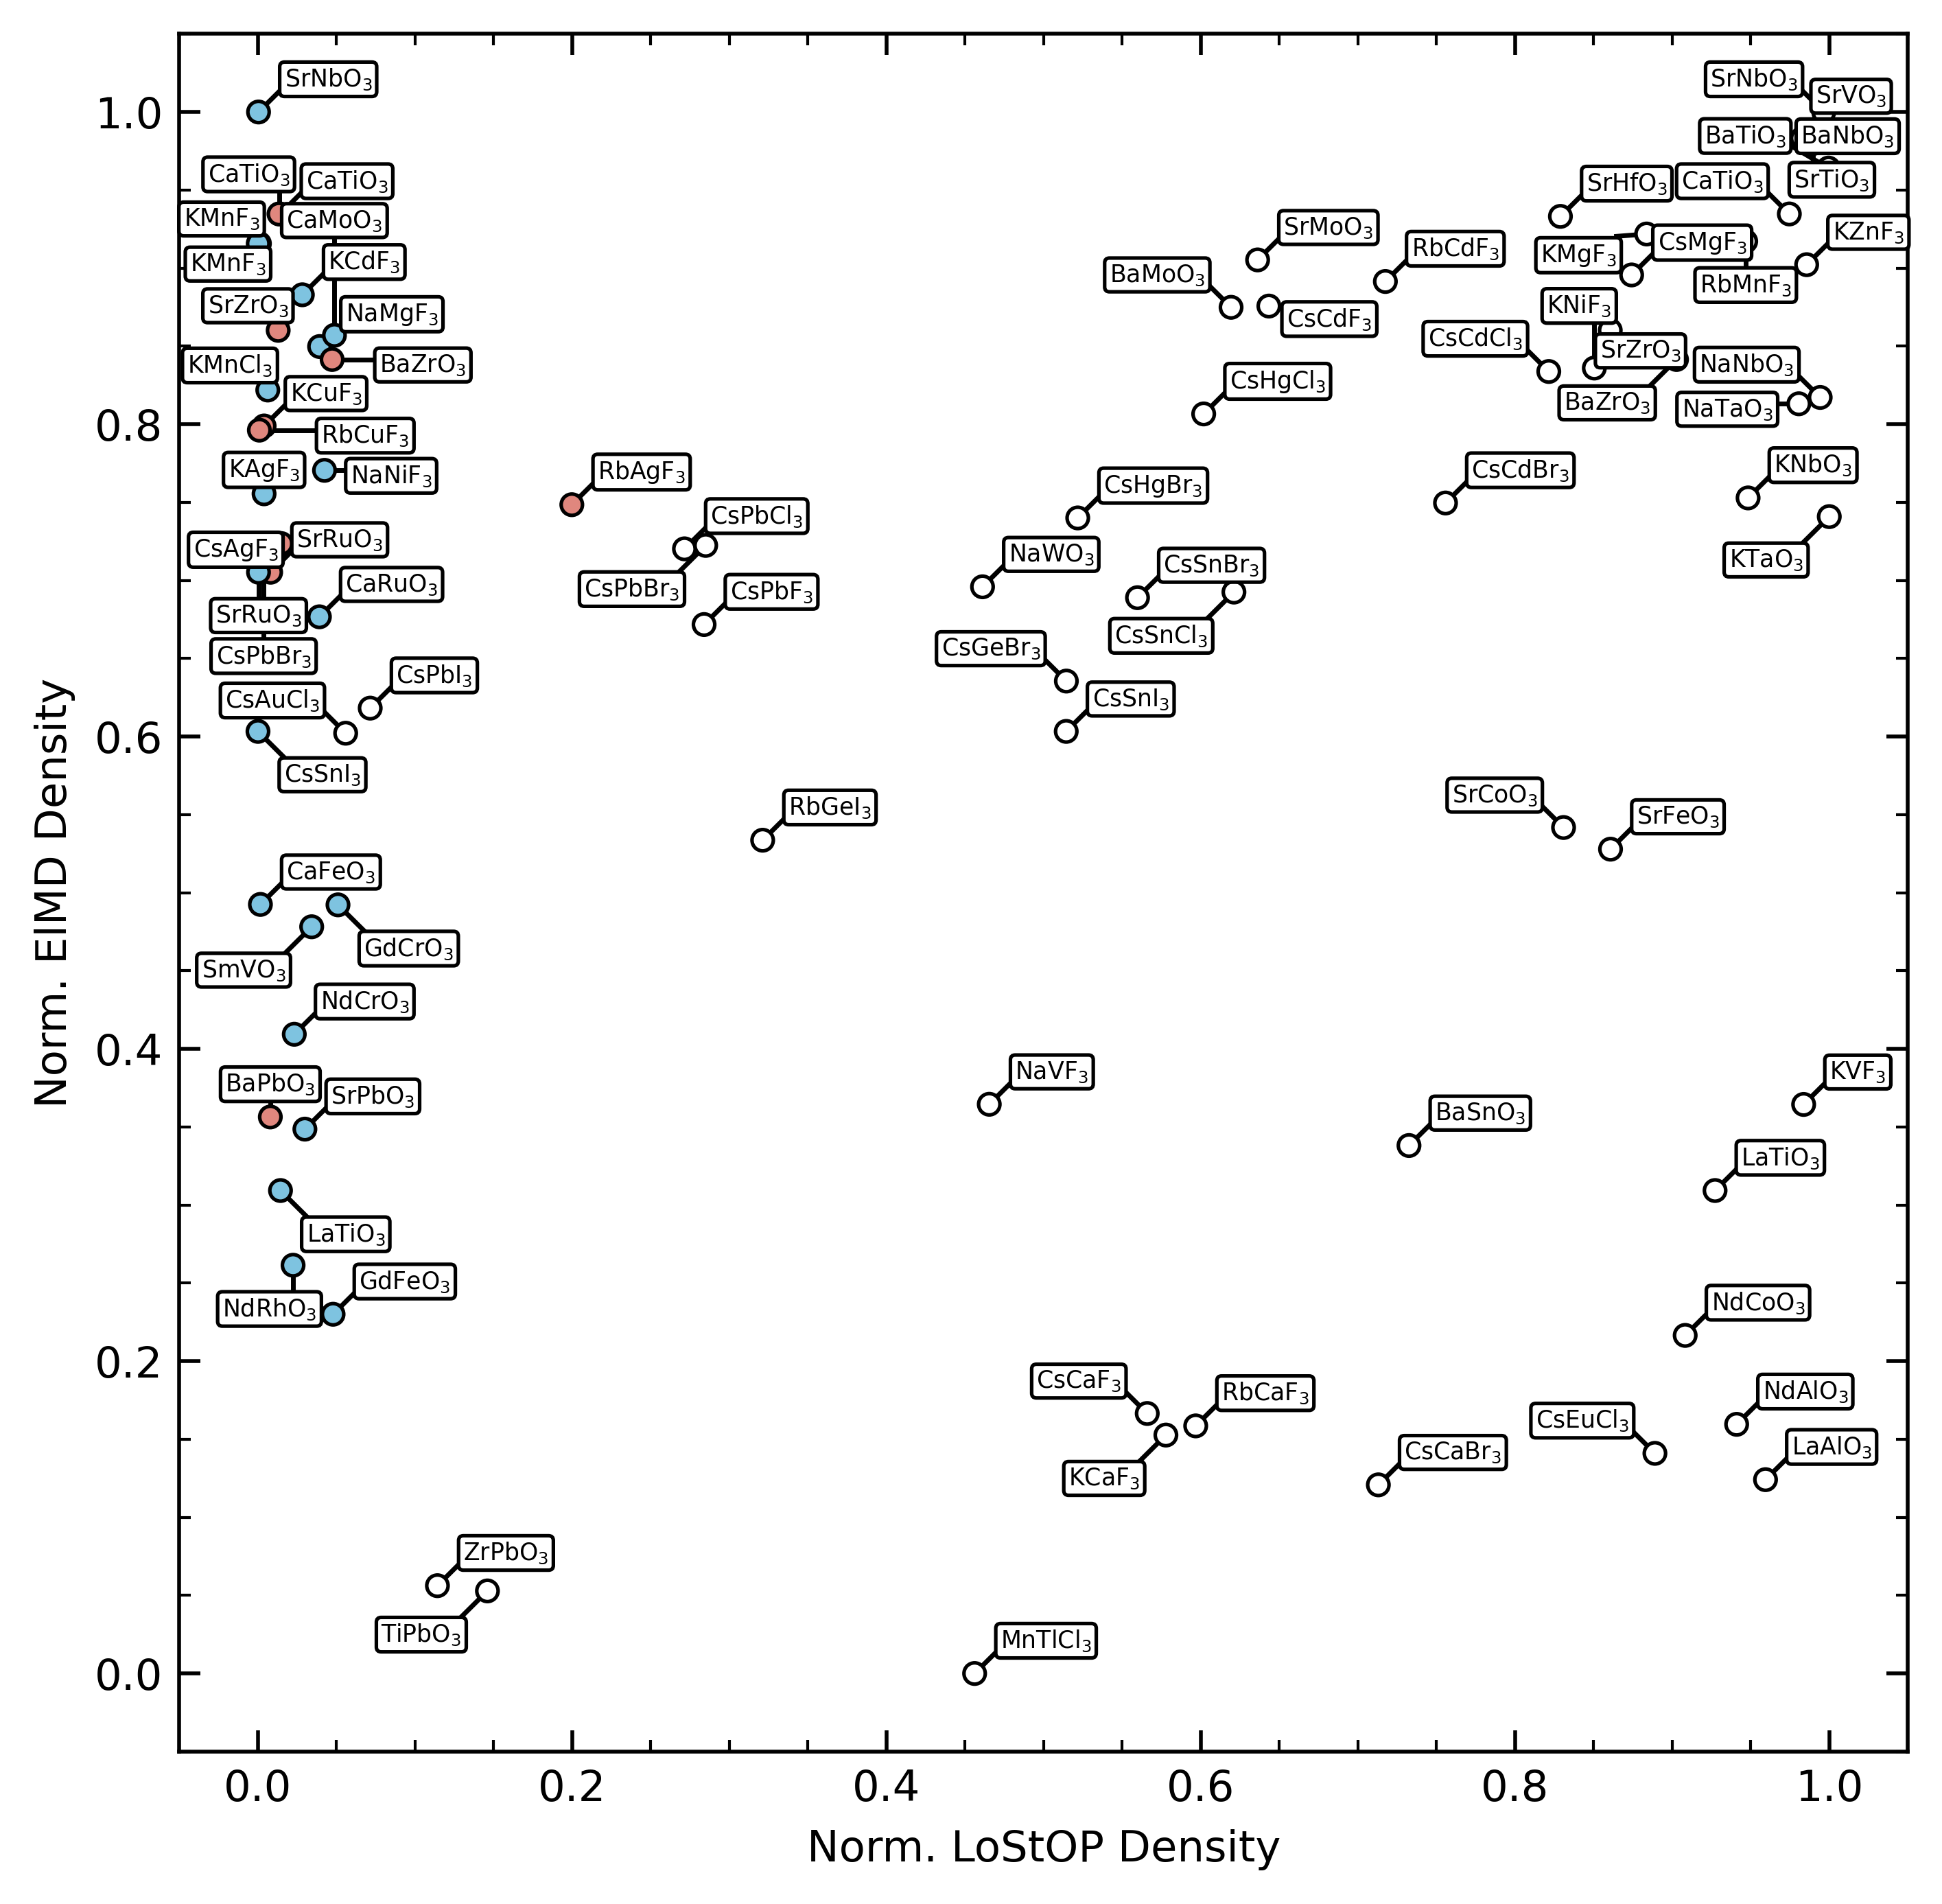

In [6]:
scaled_df = data.copy()

# scale the scaled_df
scaled_df[['lostop_density', 'elmd_density']] = MinMaxScaler().fit_transform(scaled_df[['lostop_density', 'elmd_density']])

# get some nice formula labels
labels = [reduce_single_formula(formula) for formula in scaled_df['formula'].values]

fig, ax = plt.subplots(figsize=(6.5, 6.5), dpi=500)

cmap = mpl.colors.ListedColormap(["#7EC3E0", "#E0877E", "#FFF"]) # blue, red, white, ortho, tet, cube
ax.scatter(scaled_df['lostop_density'], scaled_df['elmd_density'], c=scaled_df['spacegroup'], cmap=cmap, s=20, zorder=9, lw=0.75, ec='k')

ta.allocate(ax,
            x=scaled_df['lostop_density'],
            y=scaled_df['elmd_density'],
            text_list=labels,
            x_scatter=scaled_df['lostop_density'].values,
            y_scatter=scaled_df['elmd_density'].values,
            textsize=5,
            min_distance=0.015,
            max_distance=0.07,
            nbr_candidates=1000,
            linecolor='k',
            avoid_crossing_label_lines=True,
            avoid_label_lines_overlap=True,
            bbox=dict(boxstyle="round", fc="w", ec="k", pad=0.2, lw=0.75),
            zorder=15,
            )

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

# Set labels
ax.set_xlabel("Norm. LoStOP Density")
ax.set_ylabel("Norm. ElMD Density")
plt.show()

### Assess cubic novelty correlations with electronegativity differences

In [7]:
from pymatgen.analysis.bond_valence import BVAnalyzer
from pymatgen.analysis.local_env import CrystalNN
from matminer.featurizers.site.fingerprint import CrystalNNFingerprint
from pymatgen.core.periodic_table import Element

structures = data[data['spacegroup']==221]['structure'].tolist()

results = []

# Crystal NN analyzer for coordination environment
cnn = CrystalNN()
cnnf = CrystalNNFingerprint.from_preset("ops")

for idx, structure in enumerate(structures):
    # Try to get oxidation states, it fails on CsAuCl3 so we add manually
    try:
        structure_with_oxi = BVAnalyzer().get_oxi_state_decorated_structure(structure)
    except:
        "here"
        structure.add_oxidation_state_by_element({"Cs": 1, "Au": 2, "Cl": -1})
        structure_with_oxi = structure

    # Identify A, B, X sites
    anion_sites = [site for site in structure_with_oxi.sites if site.specie.oxi_state < 0]
    cation_sites = [site for site in structure_with_oxi.sites if site.specie.oxi_state > 0]
    
    # Sort cations based on minimum distance to anions to identify A and B cations
    sorted_cations = sorted(
        set([site.specie.element.symbol for site in cation_sites]), 
        key=lambda cat: min([
            structure_with_oxi.get_distance(
                structure_with_oxi.sites.index(cat_site), 
                structure_with_oxi.sites.index(an_site)
            ) 
            for cat_site in cation_sites if cat_site.specie.element.symbol == cat 
            for an_site in anion_sites
        ])
    )
    
    # B cation is closest to anions, A cation is furthest
    b_element = sorted_cations[0]
    a_element = sorted_cations[-1]
    x_element = anion_sites[0].specie.element.symbol
    
    # Get indices of X anions
    x_indices = [i for i, site in enumerate(structure_with_oxi.sites) 
                if site.specie.element.symbol == x_element]
    
    
    # Get CN2 weight values for X anions
    x_cn2_weights = []
    for x_idx in x_indices:
        n_sites = len(structure)
        feat = cnnf.featurize(structure, n_sites-1)
        x_cn2_weights.append(feat[2])

    # Get electronegativity values
    a_element_obj = Element(a_element)
    b_element_obj = Element(b_element)
    x_element_obj = Element(x_element)
    
    a_electronegativity = a_element_obj.X
    b_electronegativity = b_element_obj.X
    x_electronegativity = x_element_obj.X
    
    # Calculate electronegativity differences
    a_x_diff = abs(a_electronegativity - x_electronegativity)
    b_x_diff = abs(b_electronegativity - x_electronegativity)
    
    avg_cn2_weight = np.mean(x_cn2_weights) if x_cn2_weights else None

    # Store results
    result = {
        'Formula': structure.composition.reduced_formula,
        'A_element': a_element,
        'B_element': b_element,
        'X_element': x_element,
        "Avg_CN2_weight": avg_cn2_weight,
        'A_X_electronegativity_diff': a_x_diff,
        'B_X_electronegativity_diff': b_x_diff,
    }
    results.append(result)

result = pd.DataFrame(results)

Plot electronegativity differences LoStOP 2-fold coordination feature weight.

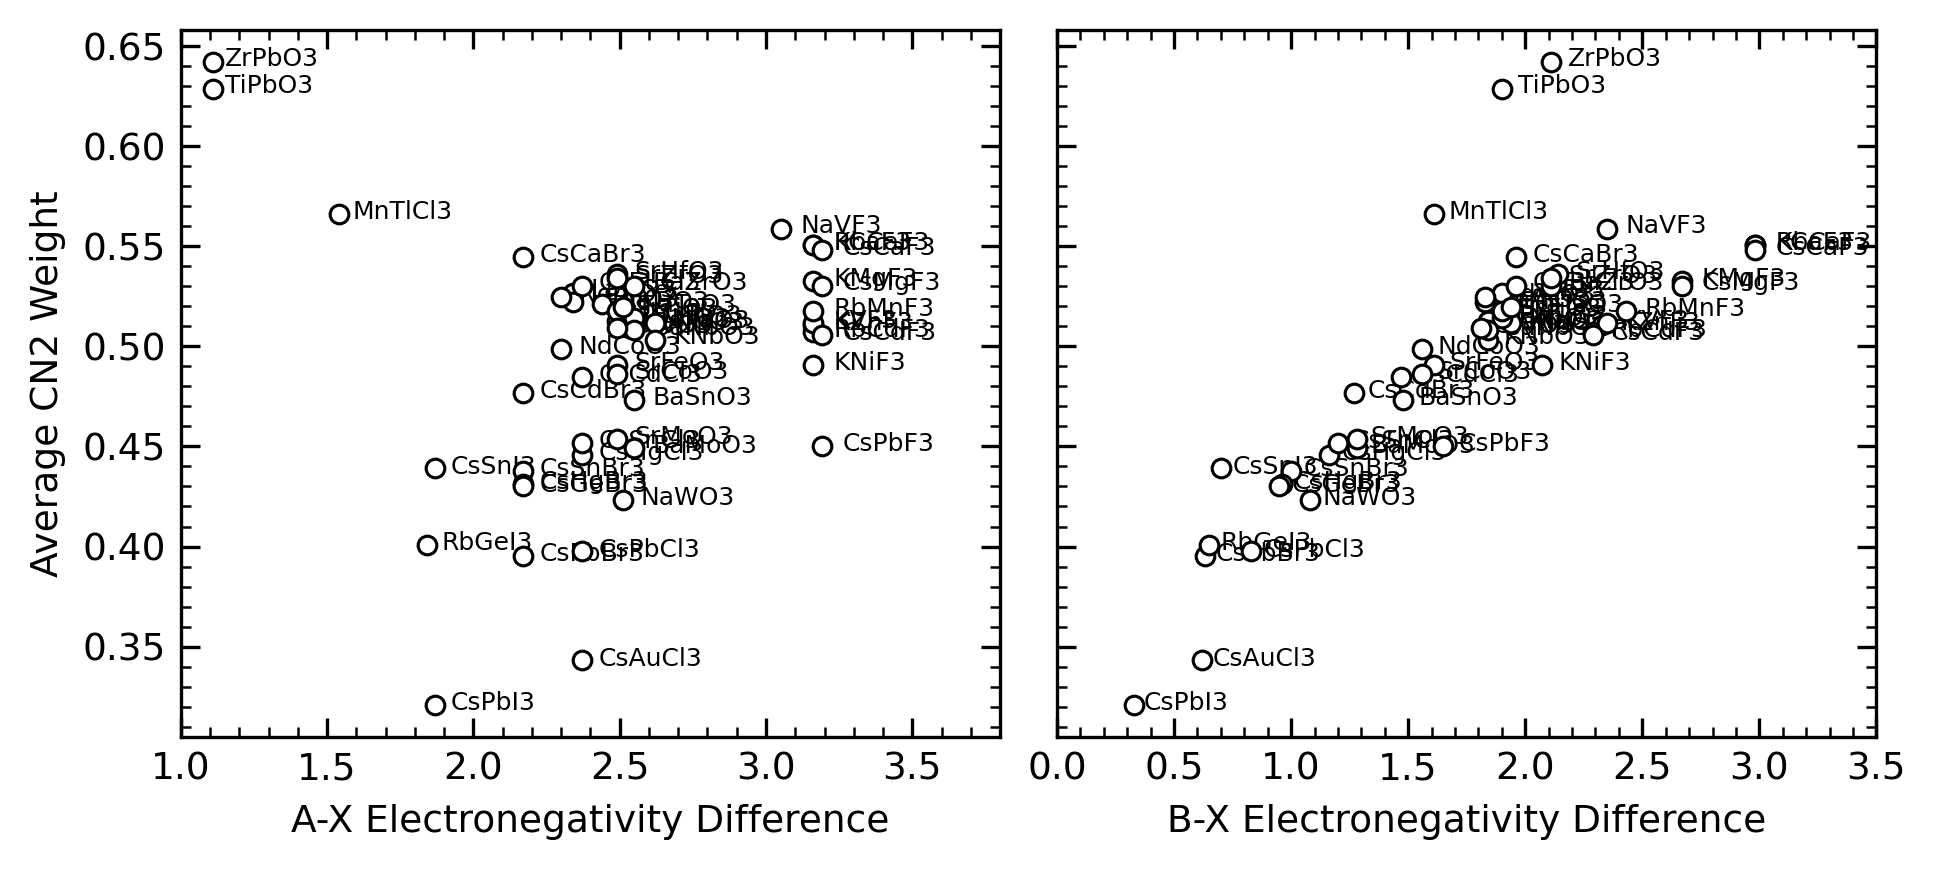

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(6.5, 3), dpi=300, sharey=True, layout='tight')

ax[0].scatter(result['A_X_electronegativity_diff'], result['Avg_CN2_weight'],  s=20, zorder=9, lw=0.75, ec='k', fc='w')
ax[0].set_xlabel("A-X Electronegativity Difference", loc='center')
ax[0].set_ylabel("Average CN2 Weight")

ax[1].scatter(result['B_X_electronegativity_diff'], result['Avg_CN2_weight'], s=20, zorder=9, lw=0.75, ec='k', fc='w')
ax[1].set_xlabel("B-X Electronegativity Difference", loc='center')

# annotate with fomula
for i, txt in enumerate(result['Formula']):
    ax[0].annotate(txt, (result['A_X_electronegativity_diff'][i]+0.025, result['Avg_CN2_weight'][i]), fontsize=6, ha='left', va='center', textcoords='offset points')
    ax[1].annotate(txt, (result['B_X_electronegativity_diff'][i]+0.035, result['Avg_CN2_weight'][i]), fontsize=6, ha='left', va='center', textcoords='offset points')

ax[0].set_xlim(1.0, 3.8)
ax[1].set_xlim(0.0, 3.5)

plt.show()

### Analysis of Novelty
Here we assess the coordination environments that make each compound unique relative to its neighbors.

In [9]:
# Get the features and fingerprint of the reference compound (idx=59)
idx = 72 # CsAuCl3
from MINOV.distance import process_structure

idx = 55 # WCl2
print(f"Reference compound formula: {data.loc[idx, 'formula']}")
reference_fp, reference_feats = process_structure(0, data.loc[idx, "structure"])

# Find 30 (arbitrary) nearest neighbors
lostop_dm = np.load("precomputed/perovskite_dataset_lostop_dm.npy")
nearest = np.argsort(lostop_dm[idx])[1:50]

# Initialize lists to store differences
feature_diffs = []
neighbor_info = []
neighbor_fps = []

# Compare each neighbor with the reference
for neighbor in tqdm(nearest):
    # Get neighbor fingerprint
    neighbor_fp, neighbor_feats = process_structure(0, data.loc[neighbor, "structure"])
    neighbor_info.append((neighbor, data.loc[neighbor, "formula"]))
    neighbor_fps.append(neighbor_fp)
    
    # Calculate absolute differences for each feature
    diffs = np.array(reference_fp) - np.array(neighbor_fp)
    feature_diffs.append(diffs)

# Convert to numpy array for easier manipulation
feature_diffs = np.array(feature_diffs)

# Calculate average difference for each feature across all neighbors
avg_diffs = np.mean(feature_diffs, axis=0)

# Get indices of features sorted by average difference (largest first)
sorted_feature_indices = np.argsort(avg_diffs)[::-1]

# Print the features with the largest differences
print("\nFeatures with largest differences between reference and neighbors:")

for i, feat_idx in enumerate(sorted_feature_indices[:3]):
    print(f"\n{i+1}. Feature {reference_feats[feat_idx]}: Average difference = {avg_diffs[feat_idx]:.4f}")
    print(f"   Reference value: {reference_fp[feat_idx]}")
    print("   Neighbor values:")
    for j, (neighbor, formula) in enumerate(neighbor_info[:5]):
        print(f"      {formula} (ID: {neighbor}): {neighbor_fps[j][feat_idx]:.4f} (Diff: {feature_diffs[j][feat_idx]:.4f})")

Reference compound formula: Cs4 Ag4 F12


100%|██████████| 49/49 [00:03<00:00, 15.28it/s]


Features with largest differences between reference and neighbors:

1. Feature maximum_sgl_bd CN_1: Average difference = 0.1370
   Reference value: 0.14261216853455932
   Neighbor values:
      K4 Cu4 F12 (ID: 11): 0.2122 (Diff: -0.0696)
      Rb4 Ag4 F12 (ID: 83): 0.0609 (Diff: 0.0817)
      Ba4 Zr4 O12 (ID: 54): 0.0000 (Diff: 0.1426)
      Rb1 Mn1 F3 (ID: 58): 0.0000 (Diff: 0.1426)
      K1 V1 F3 (ID: 35): 0.0000 (Diff: 0.1426)

2. Feature maximum_wt CN_1: Average difference = 0.1370
   Reference value: 0.14261216853455932
   Neighbor values:
      K4 Cu4 F12 (ID: 11): 0.2122 (Diff: -0.0696)
      Rb4 Ag4 F12 (ID: 83): 0.0609 (Diff: 0.0817)
      Ba4 Zr4 O12 (ID: 54): 0.0000 (Diff: 0.1426)
      Rb1 Mn1 F3 (ID: 58): 0.0000 (Diff: 0.1426)
      K1 V1 F3 (ID: 35): 0.0000 (Diff: 0.1426)

3. Feature maximum_square co-planar CN_4: Average difference = 0.1063
   Reference value: 0.11221294389022517
   Neighbor values:
      K4 Cu4 F12 (ID: 11): 0.1781 (Diff: -0.0659)
      Rb4 Ag4 F12 (ID

Assess the median novelty of each structure group.

In [10]:
print("cubic", scaled_df[scaled_df['spacegroup'] == 221]['lostop_density'].median())
print("tetragonal", scaled_df[scaled_df['spacegroup'] == 140]['lostop_density'].median())
print("orthorhombic", scaled_df[scaled_df['spacegroup'] == 62]['lostop_density'].median())

cubic 0.7886313717858349
tetragonal 0.010460735945204302
orthorhombic 0.022336386425794497


Assess the median novelty of each anion group.

['O3', 'Cl3', 'F3', 'Br3', 'I3'] [np.float64(0.8131398992285763), np.float64(0.6925448010681484), np.float64(0.8360126848133553), np.float64(0.7056996025127307), np.float64(0.6033302753503221)] [np.int64(25), np.int64(7), np.int64(13), np.int64(6), np.int64(3)]


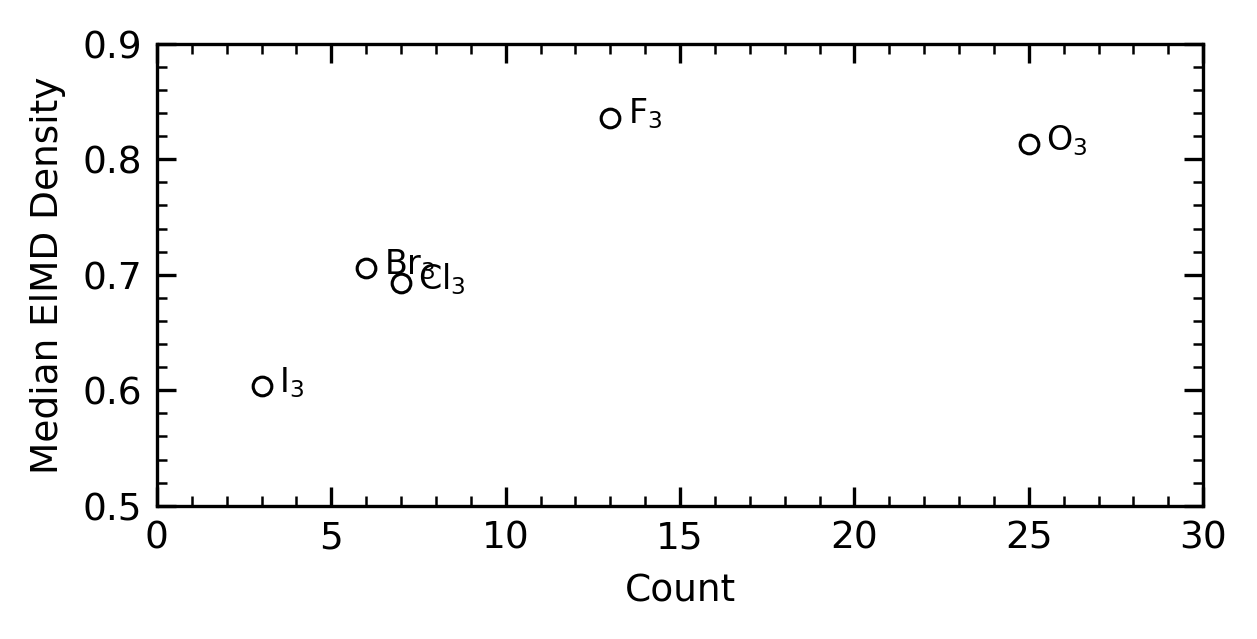

In [11]:
units = ['O3', "Cl3", "F3", "Br3", "I3"]
means = []
medians = []
counts = []

for unit in units:
    means.append(scaled_df[scaled_df['formula'].str.contains(unit)]['elmd_density'].mean())
    medians.append(scaled_df[scaled_df['formula'].str.contains(unit)]['elmd_density'].median())
    counts.append(scaled_df[scaled_df['formula'].str.contains(unit)]['elmd_density'].count())

print(units, medians, counts)

fig, ax = plt.subplots(figsize=(4.5, 2), dpi=300)

# plt.scatter(counts, means)
plt.scatter(counts, medians, s=20, fc='w', ec='k', lw=0.75)

units = ['O$_3$', "Cl$_3$", "F$_3$", "Br$_3$", "I$_3$"]
for i, unit in enumerate(units):
    plt.annotate(unit, (counts[i]+0.5, medians[i]-0.005), fontsize=8)

plt.xlabel("Count")
plt.ylabel("Median ElMD Density")

plt.ylim(0.5, 0.9)
plt.xlim(0, 30)
plt.show()

